In [1]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None
    def fit(self, X, y):
        # Separate the data into three classes
        C1 = X[y[:,0]==0]
        C2 = X[y[:,0]==1]
        C3 = X[y[:,0]==2]
        # print(C3.shape)
        
        # Calculate the mean vectors of the three classes
        m1 = np.mean(C1, axis=0)
        m2 = np.mean(C2, axis=0)
        m3 = np.mean(C3, axis=0)
        self.mean_vectors = np.array([m1, m2, m3])
        
        # Compute the within-class scatter matrix self.sw
        self.sw = np.zeros((X.shape[1], X.shape[1]))
        self.sw += (C1-m1).T @ (C1-m1)
        self.sw += (C2-m2).T @ (C2-m2)
        self.sw += (C3-m3).T @ (C3-m3)
        #print("sw", self.sw.shape)

        # Compute the between-class scatter matrix self.sb
        self.sb = np.zeros((X.shape[1], X.shape[1]))
        self.sb += C1.shape[0] * (m1 - np.mean(X, axis=0)) @ (m1 - np.mean(X, axis=0)).T
        self.sb += C2.shape[0] * (m2 - np.mean(X, axis=0)) @ (m2 - np.mean(X, axis=0)).T
        self.sb += C3.shape[0] * (m3 - np.mean(X, axis=0)) @ (m3 - np.mean(X, axis=0)).T
        #print("sb", self.sb.shape)

        # Compute the eigenvalues and eigenvectors of self.sw^-1 * self.sb
        sw_inv = np.linalg.inv(self.sw)
        M = sw_inv @ self.sb
        eigenvalues, eigenvectors = np.linalg.eig(M)
        
        indices = np.argmin(eigenvalues)
        eigenvalues = eigenvalues[indices]
        self.w = eigenvectors[indices]
        #print("eigens", eigenvalues.shape, eigenvectors.shape)
        #print('w', self.w.shape)

    def predict_using_class_mean(self, X, y, X_test):
        proj_mean = self.mean_vectors @ self.w.reshape((-1, 1))
        y_pred = X_test @ self.w.reshape((-1, 1))
        d = np.ones((self.mean_vectors.shape[0], 1))
        for i in range(len(y_pred)):
            d[0] = (y_pred[i,0] - proj_mean[0]) ** 2
            d[1] = (y_pred[i,0] - proj_mean[1]) ** 2
            d[2] = (y_pred[i,0] - proj_mean[2]) ** 2
            y_pred[i,0] = np.argmin(d, axis = 0)
        # print(y_pred)
        return y_pred

    def predict_using_knn(self, X, y, X_test, k=1):
        y_pred = X_test @ self.w.reshape((-1, 1))
        proj_X = X @ self.w.reshape((-1,1))
        dist = np.zeros((X.shape[0],1))
        for i in range(X_test.shape[0]):
            dist = (y_pred[i,0] - proj_X[:,0]) ** 2
            dist = np.argsort(dist, axis = 0)
            cnt = np.array([0,0,0])
            for j in range(k):
                cnt[y[dist[k], 0]] += 1
            y_pred[i,0] = np.argmax(cnt)
        # print(y_pred.reshape((1,-1)))
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        m = np.zeros((3,3))
        for i in range(y.shape[0]):
            m[y[i,0], int(y_pred[i,0])] += 1
        print(m)

    def plot_projection(self, X, y):
        C1 = X[y[:,0]==0]
        C2 = X[y[:,0]==1]
        C3 = X[y[:,0]==2]
        proj = (X @ self.w).reshape((-1,1)) * self.w / (self.w @ self.w)
        proj_c1 = proj[y[:,0] == 0]
        proj_c2 = proj[y[:,0] == 1]
        proj_c3 = proj[y[:,0] == 2]
        print(proj_c2.shape)
        
        #space
        up = np.max(proj[:, 0]) + 1
        low = np.min(proj[:, 0]) - 1
        x = [low, up]
        slope = self.w[1] / self.w[0]
        y = [slope*x[0], slope*x[1]]
        
        #line
        plt.plot(x, y, lw=1, c='k')
        
        #data
        plt.plot(C1[:,0], C1[:,1], 'r.', label="class 0")
        plt.plot(C2[:,0], C2[:,1], 'g.', label="class 1")
        plt.plot(C3[:,0], C3[:,1], 'b.', label="class 2")
        
        #projected data
        plt.plot(proj_c1[:,0], proj_c1[:,1], 'r.')
        plt.plot(proj_c2[:,0], proj_c2[:,1], 'g.')
        plt.plot(proj_c3[:,0], proj_c3[:,1], 'b.')
        
        for i in range(X.shape[0]):
            plt.plot([X[i,0], proj[i,0]], [X[i,1], proj[i,1]], lw=0.1, c='pink')
        
        plt.title("Projection line: w={}, b=0" .format(self.w))
        plt.legend(loc=0)

    def accuracy_score(self, y, y_pred):
        cnt = 0
        for i in range(y.shape[0]):
            if y[i,0] == int(y_pred[i,0]):
                cnt += 1
        return cnt / y.shape[0]

In [3]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        self.EPS = 1e-7

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        self.weights = np.random.randn(X.shape[1], 3)
        self.bias = np.zeros(3)
           
        y = y.astype(int)
        one_hot = np.zeros((y.shape[0], 3))
        one_hot[range(y.shape[0]), y[:,0]] = 1
        for i in range(epoch):           
            for j in range(len(X)//batch_size): 
                start = j * batch_size
                end = start + batch_size
                
                linear = X[start:end] @ self.weights
                pred = self.softmax(linear)
                
                error = (pred - one_hot[start:end]) / y[start:end].shape[0]
                grad_weights = X[start:end].transpose() @ error
                
                self.weights -= grad_weights * lr
                
                
            probs, y_hat = self.predict(X)
            self.train_loss.append(self.cross_entropy(y, probs))
            self.epoch.append(i)
            if self.train_loss[-1] < 0.7:
                lr = min(lr, 0.9)
            elif self.train_loss[-1] < 0.5:
                break

            if i%500 == 0:
                print(f'epoch: {i} loss = {self.train_loss[i]}')

    def predict(self, X):
        probs = self.softmax(X @ self.weights)
        y_hat = np.argmax(probs, axis=1).reshape((-1, 1))
        return probs, y_hat
        #pass

    def evaluate(self, X, y):
        probs, y_hat = self.predict(X)
        return self.accuracy_score(y, y_hat)

    def softmax(self, z):
        Max = np.max(z,axis=1,keepdims=True) #returns max of each row and keeps same dims
        e_x = np.exp(z - Max) #subtracts each row with its max value
        Sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
        f_x = e_x / Sum 
        return f_x

    def cross_entropy(self, y, probs):
        loss = (-1/y.shape[0]) * np.sum(np.log(probs[range(y.shape[0]), y[:,0]]))
        return loss
    
    def accuracy_score(self, y, y_pred):
        acc = 0.0
        for i in range(y.shape[0]):
            if int(y[i,0]) == int(y_pred[i]):
                acc += 1
        return acc / y.shape[0]

    def show_confusion_matrix(self, X, y):
        probs, y_hat = self.predict(X)
        y = y.astype(int)
        m = np.zeros((3,3))
        for i in range(len(y)):
            m[y[i,0], y_hat[i]] += 1
        
        print(m)

    def plot_curve(self):
        plt.plot(self.epoch, self.train_loss)
        plt.show()

# Prepare data for Q1 ~ Q12

In [4]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [5]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000, 1)
X_test (1000, 2)
y_test (1000, 1)


# MultiClass Logistic Regression

In [6]:
# For Q1
lr = 0.003
batch_size = 50
epoch = 10000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)


epoch: 0 loss = 0.7624237477129939
epoch: 500 loss = 0.2487372723900971
epoch: 1000 loss = 0.24776667992921575
epoch: 1500 loss = 0.24754196767303333
epoch: 2000 loss = 0.24744000776994318
epoch: 2500 loss = 0.24738113810052403
epoch: 3000 loss = 0.24734262449760577
epoch: 3500 loss = 0.24731538917891385
epoch: 4000 loss = 0.24729507172633924
epoch: 4500 loss = 0.24727931076894571
epoch: 5000 loss = 0.24726671387558213
epoch: 5500 loss = 0.24725640578244104
epoch: 6000 loss = 0.24724780816912323
epoch: 6500 loss = 0.2472405232896167
epoch: 7000 loss = 0.24723426842782492
epoch: 7500 loss = 0.24722883701235784
epoch: 8000 loss = 0.24722407453063655
epoch: 8500 loss = 0.24721986305628632
epoch: 9000 loss = 0.24721611099456953
epoch: 9500 loss = 0.24721274609978844


In [7]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.895


In [8]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.884


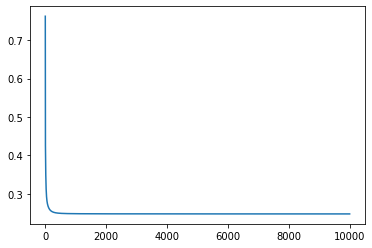

In [9]:
# For Q4
logistic_reg.plot_curve()

In [10]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

[[283.   0.  57.]
 [  0. 333.   0.]
 [ 59.   0. 268.]]


# Fisher's Linear Discriminant Analysis

In [11]:
fld = FLD()

fld.fit(X_train, y_train)

In [12]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [13]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [14]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[40062.06856449 40062.06856449]
 [40062.06856449 40062.06856449]]


In [15]:
# For Q9
print("W: ", fld.w)

W:  [-0.70710678 -0.67847921]


In [16]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

FLD using class mean, accuracy:  0.886
[[281.   0.  59.]
 [  0. 333.   0.]
 [ 55.   0. 272.]]


In [17]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.839
FLD using knn (k=2), accuracy:  0.861
FLD using knn (k=3), accuracy:  0.826
FLD using knn (k=4), accuracy:  0.837
FLD using knn (k=5), accuracy:  0.843


(334, 2)


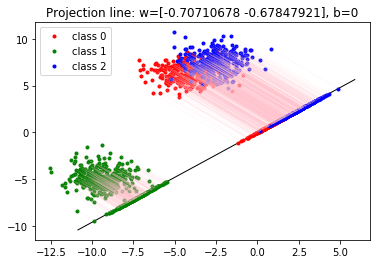

In [18]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [19]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [20]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [21]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [22]:
# Data processing
X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()
y_train = df_train[['Target']].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()
y_val = df_val[['Target']].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()

X_train[:,:2] = (X_train[:,:2] * 100) ** 2
X_train[:,:-2] = (X_train[:,:-2] * 10) ** 2

X_val[:,:2] = (X_val[:,:2] * 100) ** 2
X_val[:,:-2] = (X_val[:,:-2] * 10) ** 2

X_test[:,:2] = (X_test[:,:2] * 100) ** 2

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val",  X_val.shape)
print("y_val",  y_val.shape)
print("X_test", X_test.shape)

# Refer to section "Prepare data for Q1 ~ Q12"

X_train (1703, 4)
y_train (1703, 1)
X_val (730, 4)
y_val (730, 1)
X_test (5677, 4)


epoch: 0 loss = 5.495142304630692
epoch: 500 loss = 0.613559460123901
epoch: 1000 loss = 0.48186215919888714
epoch: 1500 loss = 0.41986509311349124
epoch: 2000 loss = 0.3804698041813054
epoch: 2500 loss = 0.3579154945087015
epoch: 3000 loss = 0.3445970053335733
epoch: 3500 loss = 0.33617948780967416
epoch: 4000 loss = 0.3304619896415405
epoch: 4500 loss = 0.32632320367360684
epoch: 5000 loss = 0.323169798520455
epoch: 5500 loss = 0.32067093986371165
epoch: 6000 loss = 0.3186314231756011
epoch: 6500 loss = 0.3169294803657996
epoch: 7000 loss = 0.3154850881707024
epoch: 7500 loss = 0.3142431189495408
epoch: 8000 loss = 0.3131639953854049
epoch: 8500 loss = 0.312218289722669
epoch: 9000 loss = 0.3113834754693512
epoch: 9500 loss = 0.31064189608836573
epoch: 10000 loss = 0.30997944571902514
epoch: 10500 loss = 0.3093846807698854
epoch: 11000 loss = 0.30884820115083145
epoch: 11500 loss = 0.30836220596768643
epoch: 12000 loss = 0.307920165831963
epoch: 12500 loss = 0.3075165755682354
epoch:

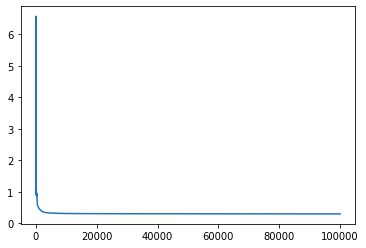

[[324.   0.   5.]
 [  3. 144.   3.]
 [ 48.   6. 197.]]


In [23]:
# Train your model here

# your_model = ...
lr = 0.02
batch_size = 15
epoch = 100000

your_model = MultiClassLogisticRegression()
your_model.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)
print("last loss", your_model.train_loss[-1])
# For Q2
print('Training acc: ', your_model.evaluate(X_train, y_train))
# For Q3
print('Valuation acc: ', your_model.evaluate(X_val, y_val))
# For Q4
your_model.plot_curve()
# # For Q5
your_model.show_confusion_matrix(X_val, y_val)


In [24]:
test_probs, test_pred = your_model.predict(X_test)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677, 1)


# Output the csv file

In [25]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")